In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_simple_network, Flatten, weight_reset, set_seed, run_epoch

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

from IPython.display import display_pdf
from IPython.display import Latex

/tmp/ipykernel_6515/2465435892.py:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [3]:
torch.backends.cudnn.deterministic=True
set_seed(45)

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

### Modify the train_network function to accept lr_schedule=ReduceLROnPlateau as a valid argument. If the train_network function gets this string argument, it should check whether validation and test sets have been provided and, if so, set up the ReduceLROnPlateau scheduler appropriately.

In [5]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None, epochs=50, device="cpu", checkpoint_file=None, lr_schedule=None, optimizer=None, disable_tqdm=False):
    """Train simple neural networks

    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs.
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use.
    optimizer -- the method used to alter the gradients for learning.

    """
    if score_funcs == None:
        score_funcs = {}#Empty set

    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )

    total_train_time = 0 #How long have we spent in the training loop?
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())

    if val_loader is not None and test_loader is not None \
        and lr_schedule == "ReduceLROnPlateau":
        lr_schedule = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min')

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")

        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )


        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")

        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()

        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)

    return pd.DataFrame.from_dict(results)

### Rerun the experiments with AdamW, SGD with Nesterov momentum, and the cosine annealing schedule using batch sizes of B = 1, 4, 32, 64, 128. How does the change in batch size impact the effectiveness and accuracy of these three tools?

In [6]:
epochs = 5 #epochs of training
B = [1, 4, 32, 64, 128] # a respectable average batch size
train_data = torchvision.datasets.FashionMNIST("/dslab/data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("/dslab/data", train=False, transform=transforms.ToTensor(), download=True)

In [7]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#Hidden layer size
n = 128
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

fc_model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n,  n),
    nn.Tanh(),
    nn.Linear(n, classes),
)

In [8]:
eta_0 = 0.001

In [9]:
loss_func = nn.CrossEntropyLoss()

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Training:   0%|          | 0/60000 [00:00<?, ?it/s]

Testing:   0%|          | 0/10000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Training:   0%|          | 0/15000 [00:00<?, ?it/s]

Testing:   0%|          | 0/2500 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Training:   0%|          | 0/1875 [00:00<?, ?it/s]

Testing:   0%|          | 0/313 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Training:   0%|          | 0/938 [00:00<?, ?it/s]

Testing:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

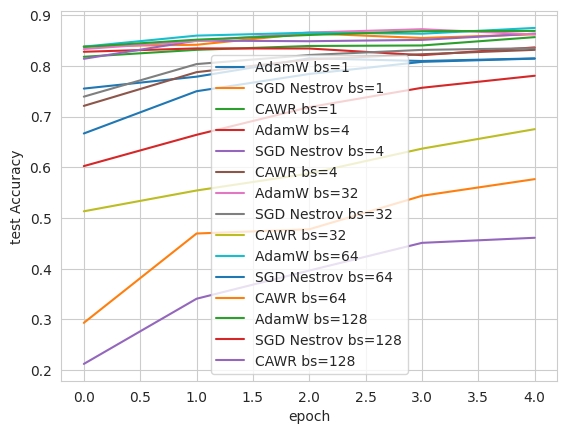

In [10]:
for batch_size in B:
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size)

    # AdamW
    fc_results_adamw = train_network(fc_model, loss_func, train_loader, test_loader=test_loader, epochs=epochs, optimizer=torch.optim.AdamW(fc_model.parameters(), lr=eta_0), score_funcs={'Accuracy': accuracy_score}, device=device)
    fc_model.apply(weight_reset)

    # SGD Nesterov
    fc_results_sgd_nesterov = train_network(fc_model, loss_func, train_loader, test_loader=test_loader, optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0, momentum=0.9, nesterov=True), epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)
    fc_model.apply(weight_reset)

    # Cosine Annealing Warm Restarts
    fc_results_cawr = train_network(fc_model, loss_func, train_loader, test_loader=test_loader, epochs=epochs, optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0), lr_schedule=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(torch.optim.SGD(fc_model.parameters(), lr=eta_0), 25, T_mult=1, eta_min=5e-5, last_epoch=- 1, verbose=False), score_funcs={'Accuracy': accuracy_score}, device=device)
    fc_model.apply(weight_reset)

    sns.lineplot(x='epoch', y='test Accuracy', data=fc_results_adamw, label='AdamW bs='+str(batch_size))
    sns.lineplot(x='epoch', y='test Accuracy', data=fc_results_sgd_nesterov, label='SGD Nestrov bs='+str(batch_size))
    sns.lineplot(x='epoch', y='test Accuracy', data=fc_results_cawr, label='CAWR bs='+str(batch_size))


Its just 5 epochs but every optimizer behaves a little different. However, most of them end around an accuracy of 0.8. Batch sizes like >=32 are not very well seen for Cosine Annealing Warm Restarts. For the rest it seems like it doesn't have a huge negative impact.

### Write code that creates a neural network with n = 256 neurons and an argument to control how many hidden layers are in the network. Then train networks with 1, 6, 12, and 24 hidden layers using naive SGD and again using AdamW with cosine annealing. How do these new optimizers impact your ability to learn these deeper networks?

In [6]:
epochs = 10 #10 epochs of training
B = 256 # a respectable average batch size
train_data = torchvision.datasets.FashionMNIST("/dslab/data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("/dslab/data", train=False, transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=B, shuffle=True)
test_loader = DataLoader(test_data, batch_size=B)

In [7]:
#How many values are in the input? We use this to help determine the size of subsequent layers
D = 28*28 #28 * 28 images
#Hidden layer size
n = 256
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

hidden_layers = [1, 6, 12, 24]
sequential_layers = [
    nn.Flatten(),
    nn.Linear(D,  n),
    nn.Tanh(),
]

In [8]:
eta_0 = 0.001

In [9]:
loss_func = nn.CrossEntropyLoss()

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

Training:   0%|          | 0/235 [00:00<?, ?it/s]

Testing:   0%|          | 0/40 [00:00<?, ?it/s]

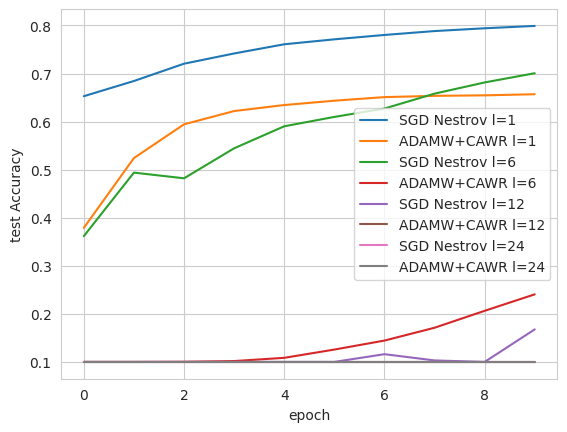

In [10]:
for layers in hidden_layers:
    # init layers for model
    model_layers = [
        nn.Flatten(),
        nn.Linear(D,  n),
        nn.Tanh(),
    ]
    # add new layers to our model
    for _ in range(layers-1):
        model_layers.append(nn.Linear(n,n))
        model_layers.append(nn.Tanh())

    # add output layer
    model_layers.append(nn.Linear(n, classes))

    # create sequential model
    fc_model = nn.Sequential(*model_layers)

    # SGD Nesterov
    fc_results_sgd_nesterov = train_network(fc_model, loss_func, train_loader, test_loader=test_loader, optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0, momentum=0.9, nesterov=True), epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)
    fc_model.apply(weight_reset)


    # Cosine Annealing Warm Restarts
    fc_results_cawr = train_network(fc_model, loss_func, train_loader, test_loader=test_loader, epochs=epochs, optimizer=torch.optim.SGD(fc_model.parameters(), lr=eta_0), lr_schedule=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(torch.optim.AdamW(fc_model.parameters(), lr=eta_0), 25, T_mult=1, eta_min=5e-5, last_epoch=- 1, verbose=False), score_funcs={'Accuracy': accuracy_score}, device=device)
    fc_model.apply(weight_reset)

    sns.lineplot(x='epoch', y='test Accuracy', data=fc_results_sgd_nesterov, label='SGD Nestrov l='+str(layers))

    sns.lineplot(x='epoch', y='test Accuracy', data=fc_results_cawr, label='ADAMW+CAWR l='+str(layers))


SGD Nestrov performs better with less hidden layers. AdamW + CAWR with more hidden layers seems to need more time. AdamW + CAWR with less layers starts well but get very soon stacked.

### Retrain the three-layer bidirectional RNN from the last chapter with each of the new optimizers from this chapter. How do they impact the results? && Add gradient clipping to the experiments from exercise 4. Does it help or hurt the RNN?

both examples are done in one snippet

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Training:   0%|          | 0/5019 [00:00<?, ?it/s]

Testing:   0%|          | 0/5019 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

Training:   0%|          | 0/2510 [00:00<?, ?it/s]

Testing:   0%|          | 0/2510 [00:00<?, ?it/s]

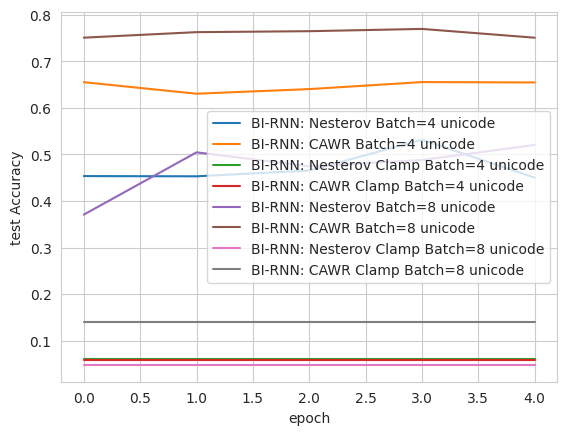

In [6]:
namge_language_data = {}

zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
#z = zipfile.ZipFile('data.zip')
z.extractall()

#We will use some code to remove UNICODE tokens to make life easy for us processing wise
#e.g., convert something like "Ślusàrski" to Slusarski
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

#Loop through every language, open the zip file entry, and read all the lines from the text file.
for zip_path in z.namelist():
    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower() for line in str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names)) #Print out the name of each language too.

def norm_input(batch):

    tensor_data, tensor_label = [], []
    for td, tl in batch:
        tensor_data.append(td)
        tensor_label.append(tl)

    inputs = torch.nn.utils.rnn.pad_sequence(tensor_data, batch_first=False)
    inputs_padded = torch.nn.utils.rnn.pack_padded_sequence(inputs, [i.shape[0] for i in tensor_data],enforce_sorted=False, batch_first=False)
    labels = torch.tensor(tensor_label)

    return inputs_padded, labels

class LanguageNameDataset(Dataset):

    def __init__(self, lang_name_dict, vocabulary=None, unicode=False):
        self.label_names = [x for x in lang_name_dict.keys()]
        self.data = []
        self.labels = []
        self.all_letters = []

        for y, language in enumerate(self.label_names):
            for sample in lang_name_dict[language]:
                if unicode is False:
                    # apply unicodeToAscii
                    sample = [''.join(c for c in unicodedata.normalize('NFD', sample) if unicodedata.category(c) != 'Mn' and c in ''.join(self.label_names))]

                self.data.append(sample)
                self.labels.append(y)

        if vocabulary is None:
            self.vocabulary = {}
            self.all_letters = []
            for elem in self.data:
                for letter in elem:
                    if letter not in self.all_letters:
                        self.all_letters.append(letter)
            for i in range(len(self.all_letters)):
                self.vocabulary[self.all_letters[i]] = i
        else:
            self.vocabulary = vocabulary

    def __len__(self):
        return len(self.data)

    def string2InputVec(self, input_string):
        """
        This method will convert any input string into a vector of long values, according to the vocabulary used by this object.
        input_string: the string to convert to a tensor
        """
        T = len(input_string) #How many characters long is the string?

        #Create a new tensor to store the result in
        name_vec = torch.zeros((T), dtype=torch.long)
        #iterate through the string and place the appropriate values into the tensor
        for pos, character in enumerate(input_string):
            name_vec[pos] = self.vocabulary[character]

        return name_vec

    # def getallletters(self):
    #     return self.all_letters

    def __getitem__(self, idx):
        name = self.data[idx]
        label = self.labels[idx]

        #Conver the correct class label into a tensor for PyTorch
        label_vec = torch.tensor([label], dtype=torch.long)

        return self.string2InputVec(name), label

class LastTimeStep(nn.Module):
    """
    A class for extracting the hidden activations of the last time step
    following
    the output of a PyTorch RNN module.
    """
    def __init__(self, rnn_layers=1, bidirectional=False):
        super(LastTimeStep, self).__init__()
        self.rnn_layers = rnn_layers
        if bidirectional:
            self.num_directions = 2
        else:
            self.num_directions = 1
    def forward(self, input):
        rnn_output = input[0]
        last_step = input[1]
        if(type(last_step) == tuple):
            last_step = last_step[0]
        batch_size = last_step.shape[1]
        last_step = last_step.view(self.rnn_layers, self.num_directions, batch_size, -1)
        last_step = last_step[self.rnn_layers-1]
        last_step = last_step.permute(1, 0, 2)
        return last_step.reshape(batch_size, -1)

dataset_unicode = LanguageNameDataset(namge_language_data, vocabulary=None, unicode=True)

from idlmam import EmbeddingPackable

D = 64
eta_0 = 0.1
vocab_size_unicode = len(dataset_unicode.vocabulary) # because UNK was added
hidden_nodes = 256 #linear --> (= 256 * 2) due to bi-directional
classes = len(dataset_unicode.label_names)

bi_rnn_unicode = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size_unicode, D)), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

bi_rnn_unicode_clamp = nn.Sequential(
    EmbeddingPackable(nn.Embedding(vocab_size_unicode, D)), #(B, T) -> (B, T, D)
    nn.RNN(D, hidden_nodes, batch_first=True, bidirectional=True), #(B, T, D) -> ( (B,T,D) , (S, B, D)  )
    #the tanh activation is built into the RNN object, so we don't need to do it here
    LastTimeStep(bidirectional=True), #We need to take the RNN output and reduce it to one item, (B, D)
    nn.Linear(hidden_nodes*2, classes), #(B, D) -> (B, classes)
)

loss_func = nn.CrossEntropyLoss()
epochs = 5 #10 epochs of training
batch_size = [4,8]
for bs in batch_size:

    train_loader_unicode = DataLoader(dataset_unicode, batch_size=bs, collate_fn=norm_input, shuffle=True)
    test_loader_unicode = DataLoader(dataset_unicode, batch_size=bs, collate_fn=norm_input, shuffle=False)

    # SGD Nesterov
    bi_results_sgd_nesterov = train_network(bi_rnn_unicode, loss_func, train_loader_unicode, test_loader=test_loader_unicode, optimizer=torch.optim.SGD(bi_rnn_unicode.parameters(), lr=eta_0, momentum=0.9, nesterov=True), epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)
    bi_rnn_unicode.apply(weight_reset)

    # Cosine Annealing Warm Restarts
    bi_results_cawr = train_network(bi_rnn_unicode, loss_func, train_loader_unicode, test_loader=test_loader_unicode, epochs=epochs, optimizer=torch.optim.SGD(bi_rnn_unicode.parameters(), lr=eta_0), lr_schedule=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(torch.optim.AdamW(bi_rnn_unicode.parameters(), lr=eta_0), 25, T_mult=1, eta_min=5e-5, last_epoch=- 1, verbose=False), score_funcs={'Accuracy': accuracy_score}, device=device)
    bi_rnn_unicode.apply(weight_reset)

    for i in bi_rnn_unicode_clamp.parameters():
        i.register_hook(lambda grad: torch.clamp(grad, -5, 5))
    # SGD Nesterov
    bi_results_sgd_nesterov_clamp = train_network(bi_rnn_unicode_clamp, loss_func, train_loader_unicode, test_loader=test_loader_unicode, optimizer=torch.optim.SGD(bi_rnn_unicode.parameters(), lr=eta_0, momentum=0.9, nesterov=True), epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)
    bi_rnn_unicode_clamp.apply(weight_reset)

    for i in bi_rnn_unicode_clamp.parameters():
        i.register_hook(lambda grad: torch.clamp(grad, -5, 5))
    # Cosine Annealing Warm Restarts
    bi_results_cawr_clamp = train_network(bi_rnn_unicode_clamp, loss_func, train_loader_unicode, test_loader=test_loader_unicode, epochs=epochs, optimizer=torch.optim.SGD(bi_rnn_unicode.parameters(), lr=eta_0), lr_schedule=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(torch.optim.AdamW(bi_rnn_unicode.parameters(), lr=eta_0), 25, T_mult=1, eta_min=5e-5, last_epoch=- 1, verbose=False), score_funcs={'Accuracy': accuracy_score}, device=device)
    bi_rnn_unicode_clamp.apply(weight_reset)

    sns.lineplot(x='epoch', y='test Accuracy', data=bi_results_sgd_nesterov, label='BI-RNN: Nesterov Batch='+str(bs)+' unicode')

    sns.lineplot(x='epoch', y='test Accuracy', data=bi_results_cawr, label='BI-RNN: CAWR Batch='+str(bs)+' unicode')

    sns.lineplot(x='epoch', y='test Accuracy', data=bi_results_sgd_nesterov_clamp, label='BI-RNN: Nesterov Clamp Batch='+str(bs)+' unicode')

    sns.lineplot(x='epoch', y='test Accuracy', data=bi_results_cawr_clamp, label='BI-RNN: CAWR Clamp Batch='+str(bs)+' unicode')

CAWR with batch 4 and 8 performs much better than Nestrov Clamp

### Write your own function that uses Optuna to optimize the parameters of a fully connected neural network. Once it’s done, create a new network with those hyperparameters, train it using all of the training data, and test it on the held-out test set. What results do you get on FashionMNIST, and how close is Optuna’s guess at the accuracy compared to your test-set performance?

In [6]:
import optuna
from torch.utils.data.sampler import SubsetRandomSampler

epochs = 10 #10 epochs of training
B = 256 # a respectable average batch size

D = 28*28 #28 * 28 images
#Hidden layer size
n = 128
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

loss_func = nn.CrossEntropyLoss()

train_data = torchvision.datasets.FashionMNIST("/dslab/data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("/dslab/data", train=False, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("/dslab/data", train=False, transform=transforms.ToTensor(), download=True)

# preparing validation set
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor(0.2*len(train_data)))
train_sample = SubsetRandomSampler(indices[:split])
val_sample = SubsetRandomSampler(indices[split:])

train_loader = DataLoader(train_data, batch_size=B, sampler=train_sample)
valid_loader = DataLoader(train_data, batch_size=B, sampler=val_sample)
test_loader = DataLoader(test_data, batch_size=B)

In [7]:
# optuna objective
def objective(trial):
    # define network
    n = trial.suggest_int('neurons_per_layer', 16, 256)
    layers = trial.suggest_int('hidden_layers', 1, 6)
    eta_global = trial.suggest_float('learning_rate', 1e-5, 1e-2)

    sequential_layers = [nn.Flatten(), nn.Linear(D, n), nn.Tanh(),]

    for _ in range(layers-1):
        sequential_layers.append(nn.Linear(n, n))
        sequential_layers.append(nn.Tanh())

    sequential_layers.append(nn.Linear(n, classes) )           #3
    fc_model = nn.Sequential(*sequential_layers)

    optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_global)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min')

    for epoch in range(10):
        results = train_network(fc_model, loss_func, train_loader, val_loader=valid_loader, epochs=1, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device, disable_tqdm=True)

    cur_accuracy = results['val Accuracy'].iloc[-1]
    trial.report(cur_accuracy, epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return cur_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(study.best_params)


[I 2023-04-07 11:38:21,636] A new study created in memory with name: no-name-12505656-ce81-4b52-9b0e-865b359d96ba


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:39:32,442] Trial 0 finished with value: 0.8440833333333333 and parameters: {'neurons_per_layer': 173, 'hidden_layers': 3, 'learning_rate': 0.007336636368537259}. Best is trial 0 with value: 0.8440833333333333.


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:40:41,259] Trial 1 finished with value: 0.8489375 and parameters: {'neurons_per_layer': 191, 'hidden_layers': 4, 'learning_rate': 0.0004498810662349717}. Best is trial 1 with value: 0.8489375.


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:41:50,112] Trial 2 finished with value: 0.8352083333333333 and parameters: {'neurons_per_layer': 213, 'hidden_layers': 4, 'learning_rate': 0.006236913369755169}. Best is trial 1 with value: 0.8489375.


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:42:57,391] Trial 3 finished with value: 0.8539583333333334 and parameters: {'neurons_per_layer': 121, 'hidden_layers': 3, 'learning_rate': 0.00286171144463471}. Best is trial 3 with value: 0.8539583333333334.


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:44:05,102] Trial 4 finished with value: 0.8409583333333334 and parameters: {'neurons_per_layer': 29, 'hidden_layers': 4, 'learning_rate': 0.007974666830104815}. Best is trial 3 with value: 0.8539583333333334.


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:45:12,359] Trial 5 finished with value: 0.8475625 and parameters: {'neurons_per_layer': 227, 'hidden_layers': 2, 'learning_rate': 0.005161864814273514}. Best is trial 3 with value: 0.8539583333333334.


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:46:21,146] Trial 6 finished with value: 0.8469375 and parameters: {'neurons_per_layer': 80, 'hidden_layers': 6, 'learning_rate': 0.004290764157501385}. Best is trial 3 with value: 0.8539583333333334.


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:47:29,296] Trial 7 finished with value: 0.8566041666666667 and parameters: {'neurons_per_layer': 183, 'hidden_layers': 4, 'learning_rate': 0.0012959069217463382}. Best is trial 7 with value: 0.8566041666666667.


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:48:37,525] Trial 8 finished with value: 0.8499166666666667 and parameters: {'neurons_per_layer': 233, 'hidden_layers': 3, 'learning_rate': 0.004056984536971426}. Best is trial 7 with value: 0.8566041666666667.


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-07 11:49:39,920] Trial 9 pruned. 


{'neurons_per_layer': 183, 'hidden_layers': 4, 'learning_rate': 0.0012959069217463382}


apply results to train a new model

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='val Accuracy'>

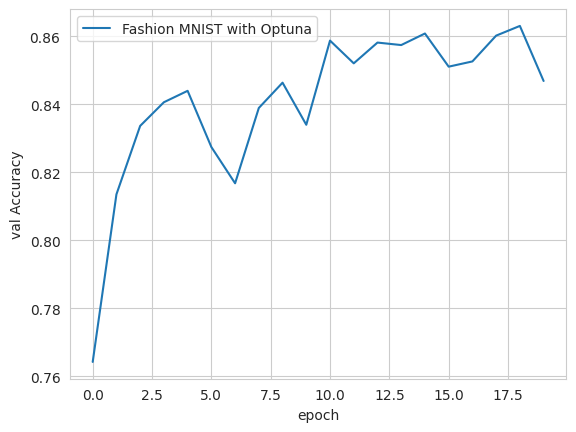

In [10]:
n = study.best_params['neurons_per_layer']
layers = study.best_params['hidden_layers']
eta_global = study.best_params['learning_rate']
sequential_layers = [nn.Flatten(), nn.Linear(D, n), nn.Tanh(),]

for _ in range(layers-1):
    sequential_layers.append(nn.Linear(n, n))
    sequential_layers.append(nn.Tanh())

sequential_layers.append(nn.Linear(n, classes) )           #3
fc_model = nn.Sequential(*sequential_layers)

optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_global)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min')

fc_model.apply(weight_reset)
results = train_network(fc_model, loss_func, train_loader, val_loader=valid_loader, epochs=20, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device, disable_tqdm=True)

sns.lineplot(x='epoch', y='val Accuracy', data=results, label='Fashion MNIST with Optuna')

Seems to be a nice model on the val set

### Redo exercise 6, but replace the hidden layers with convolutional ones and add a new argument that controls how many rounds of max pooling to perform. How does it perform on FashionMNIST compared with your results from exercise 6?

In [6]:
import optuna
from torch.utils.data.sampler import SubsetRandomSampler

epochs = 10 #10 epochs of training
B = 256 # a respectable average batch size

D = 28*28 #28 * 28 images
#Hidden layer size
n = 128
#How many channels are in the input?
C = 1
#How many classes are there?
classes = 10

loss_func = nn.CrossEntropyLoss()

train_data = torchvision.datasets.FashionMNIST("/dslab/data", train=True, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("/dslab/data", train=False, transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("/dslab/data", train=False, transform=transforms.ToTensor(), download=True)

# preparing validation set
indices = list(range(len(train_data)))
np.random.shuffle(indices)
split = int(np.floor(0.2*len(train_data)))
train_sample = SubsetRandomSampler(indices[:split])
val_sample = SubsetRandomSampler(indices[split:])

train_loader = DataLoader(train_data, batch_size=B, sampler=train_sample)
valid_loader = DataLoader(train_data, batch_size=B, sampler=val_sample)
test_loader = DataLoader(test_data, batch_size=B)

In [7]:
# demo split number in n numbers
# https://math.stackexchange.com/questions/2975936/split-a-number-into-n-numbers
n = 2
p = 1
d = int(n / p) # truncating integer division
r = int(n % p) # remainder

print(d)
print(r)

p1 = [d+1 for _ in range(r)]
p2 = [d for _ in range(p - r)]

print(p1)
print(p2)
p3 = p1 + p2
print(str(n)+" = "+str(p3))

2
0
[]
[2]
2 = [2]


In [11]:
# optuna objective
def objective(trial):
    # define network

    #n = trial.suggest_int('neurons_per_layer', 1, 16)
    layers = trial.suggest_int('conv_layers', 1, 4)
    max_pooling = trial.suggest_int('max_pooling', 0, 2)
    eta_global = trial.suggest_float('learning_rate', 1e-5, 1e-2)
    k = 3
    filters = 16

    # pre-calc num of iteration to insert max_pooling
    # example: see above
    if layers >= max_pooling and max_pooling > 0:
        p = max_pooling
        d = int(layers / max_pooling) # truncation integer division
        r = int(layers % max_pooling) # remainder
        layers_stack = [d+1 for _ in range(r)] + [d for _ in range(p-r)]
        # print("----")
        # print("d: "+str(d))
        # print("r: "+str(r))
        # print(layers_stack)
        elem_idx = layers_stack.pop()
        # print("---")
        # print(elem_idx)

    else:
        max_pooling = 0
        elem_idx = -1

    used_max_pool_flag = False
    layer_idx = 1
    layers_cnt = 1

    sequential_layers = [nn.Conv2d(C, filters, k, padding=k//2), nn.ReLU(),]

    while layers_cnt <= (layers+max_pooling):
        if layer_idx == elem_idx:
            if not used_max_pool_flag:
                sequential_layers.append(nn.Conv2d(filters, 2*filters, k, padding=k//2))
                sequential_layers.append(nn.ReLU())
                used_max_pool_flag = True
            sequential_layers.append(nn.MaxPool2d(2))
            layer_idx = 0
            if len(layers_stack) > 0:
                elem_idx = layers_stack.pop()
            else:
                elem_idx = -1
            layers_cnt +=2
        elif used_max_pool_flag:
            sequential_layers.append(nn.Conv2d(2*filters, 2*filters, k, padding=k//2))
            sequential_layers.append(nn.ReLU())
            layer_idx += 1
            layers_cnt +=1
        else:
            sequential_layers.append(nn.Conv2d(filters, filters, k, padding=k//2))
            sequential_layers.append(nn.ReLU())
            layer_idx += 1
            layers_cnt +=1

    sequential_layers.append(nn.Flatten())
    if max_pooling > 0:
        factor = 2*filters*D//(4**(max_pooling))
    else:
        factor = filters*D

#    print("max_pooling")
#    print(max_pooling)
    sequential_layers.append(nn.Linear(factor, classes))
    fc_model = nn.Sequential(*sequential_layers)
    print(fc_model)

    optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_global)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min')

    for epoch in range(10):
        results = train_network(fc_model, loss_func, train_loader, val_loader=valid_loader, epochs=1, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device, disable_tqdm=True)

    cur_accuracy = results['val Accuracy'].iloc[-1]
    trial.report(cur_accuracy, epoch)
    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()

    return cur_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print(study.best_params)

[I 2023-04-12 11:43:51,552] A new study created in memory with name: no-name-56a62951-50fc-4f30-b272-b821407c28f8


----
d: 4
r: 0
[4]
---
4
max_pooling
1
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU()
  (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (11): Flatten(start_dim=1, end_dim=-1)
  (12): Linear(in_features=6272, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:45:09,393] Trial 0 finished with value: 0.8856666666666667 and parameters: {'conv_layers': 4, 'max_pooling': 1, 'learning_rate': 0.005546218681990278}. Best is trial 0 with value: 0.8856666666666667.


----
d: 2
r: 0
[2]
---
2
max_pooling
1
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=6272, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:46:21,560] Trial 1 finished with value: 0.8906041666666666 and parameters: {'conv_layers': 2, 'max_pooling': 1, 'learning_rate': 0.00896312570627896}. Best is trial 1 with value: 0.8906041666666666.


----
d: 2
r: 0
[2, 2]
---
2
max_pooling
2
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU()
  (9): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (10): ReLU()
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=1568, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:47:36,085] Trial 2 finished with value: 0.8879166666666667 and parameters: {'conv_layers': 4, 'max_pooling': 2, 'learning_rate': 0.0018842460978240425}. Best is trial 1 with value: 0.8906041666666666.


max_pooling
0
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=12544, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:48:44,687] Trial 3 finished with value: 0.8770208333333334 and parameters: {'conv_layers': 1, 'max_pooling': 2, 'learning_rate': 0.0027602563051537807}. Best is trial 1 with value: 0.8906041666666666.


----
d: 1
r: 0
[1, 1]
---
1
max_pooling
2
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU()
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=1568, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:49:56,530] Trial 4 finished with value: 0.8896041666666666 and parameters: {'conv_layers': 2, 'max_pooling': 2, 'learning_rate': 0.008523165646541259}. Best is trial 1 with value: 0.8906041666666666.


max_pooling
0
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Flatten(start_dim=1, end_dim=-1)
  (5): Linear(in_features=12544, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:51:05,460] Trial 5 pruned. 


----
d: 2
r: 0
[2]
---
2
max_pooling
1
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Flatten(start_dim=1, end_dim=-1)
  (8): Linear(in_features=6272, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:52:19,870] Trial 6 finished with value: 0.8887083333333333 and parameters: {'conv_layers': 2, 'max_pooling': 1, 'learning_rate': 0.002330122676166005}. Best is trial 1 with value: 0.8906041666666666.


max_pooling
0
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=12544, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:53:34,447] Trial 7 pruned. 


----
d: 1
r: 0
[1]
---
1
max_pooling
1
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=6272, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:54:46,417] Trial 8 finished with value: 0.8933333333333333 and parameters: {'conv_layers': 1, 'max_pooling': 1, 'learning_rate': 0.005735094684698613}. Best is trial 8 with value: 0.8933333333333333.


max_pooling
0
Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=12544, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

[I 2023-04-12 11:56:01,721] Trial 9 pruned. 


{'conv_layers': 1, 'max_pooling': 1, 'learning_rate': 0.005735094684698613}


Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=6272, out_features=10, bias=True)
)


Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

Training:   0%|          | 0/47 [00:00<?, ?it/s]

Validating:   0%|          | 0/188 [00:00<?, ?it/s]

<AxesSubplot: xlabel='epoch', ylabel='val Accuracy'>

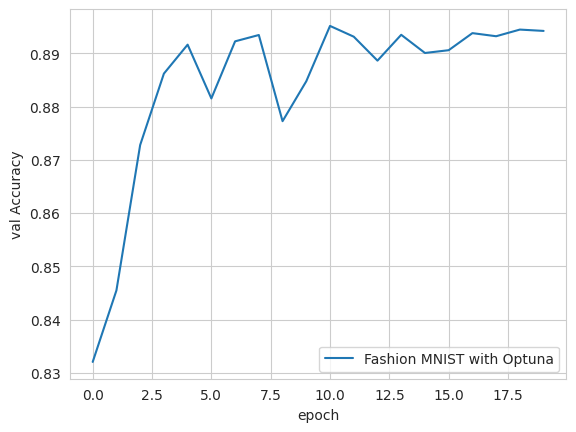

In [15]:
layers = study.best_params['conv_layers']
max_pooling = study.best_params['max_pooling']
eta_global = study.best_params['learning_rate']

k = 3
filters = 16

# pre-calc num of iteration to insert max_pooling
# example: see above
if layers >= max_pooling and max_pooling > 0:
    p = max_pooling
    d = int(layers / max_pooling) # truncation integer division
    r = int(layers % max_pooling) # remainder
    layers_stack = [d+1 for _ in range(r)] + [d for _ in range(p-r)]
    elem_idx = layers_stack.pop()
else:
    max_pooling = 0
    elem_idx = -1

used_max_pool_flag = False
layer_idx = 1
layers_cnt = 1

sequential_layers = [nn.Conv2d(C, filters, k, padding=k//2), nn.ReLU(),]

while layers_cnt <= (layers+max_pooling):
    if layer_idx == elem_idx:
        if not used_max_pool_flag:
            sequential_layers.append(nn.Conv2d(filters, 2*filters, k, padding=k//2))
            sequential_layers.append(nn.ReLU())
            used_max_pool_flag = True
        sequential_layers.append(nn.MaxPool2d(2))
        layer_idx = 0
        if len(layers_stack) > 0:
            elem_idx = layers_stack.pop()
        else:
            elem_idx = -1
        layers_cnt +=2
    elif used_max_pool_flag:
        sequential_layers.append(nn.Conv2d(2*filters, 2*filters, k, padding=k//2))
        sequential_layers.append(nn.ReLU())
        layer_idx += 1
        layers_cnt +=1
    else:
        sequential_layers.append(nn.Conv2d(filters, filters, k, padding=k//2))
        sequential_layers.append(nn.ReLU())
        layer_idx += 1
        layers_cnt +=1

sequential_layers.append(nn.Flatten())
if max_pooling > 0:
    factor = 2*filters*D//(4**(max_pooling))
else:
    factor = filters*D

# print("max_pooling")
# print(max_pooling)
sequential_layers.append(nn.Linear(factor, classes))
fc_model = nn.Sequential(*sequential_layers)
print(fc_model)

optimizer = torch.optim.AdamW(fc_model.parameters(), lr=eta_global)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min')

fc_model.apply(weight_reset)
results2 = train_network(fc_model, loss_func, train_loader, val_loader=valid_loader, epochs=20, optimizer=optimizer, lr_schedule=scheduler, score_funcs={'Accuracy': accuracy_score}, device=device, disable_tqdm=True)

sns.lineplot(x='epoch', y='val Accuracy', data=results2, label='Fashion MNIST with Optuna')

In [27]:
print("Accuracy diff between study and real model" + str(study.best_value - results2['val Accuracy'][results2.index[-1]]))

Accuracy diff between study and real model-0.0008958333333333179


<0 means real val Accracy was better than study Accuracy